In [1]:
#! /usr/bin/python
# uk-crime.ipynb  Notebooking analysing streem crime statisticsfrom the Police API published by the UK Home Office


#Created on Thu Oct 17 23:34:00 2018

#@author: Adil

In [2]:
from police_api import PoliceAPI
import pandas as pd
from matplotlib import pyplot as plt
import time
from calendar import month_name
import numpy as np
from pyproj import Proj, transform 
from geopy.geocoders import Nominatim

from IPython.core.display import display, HTML
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import output_notebook
from bokeh.models import Legend, NumeralTickFormatter,ColumnDataSource,LabelSet,DatetimeTickFormatter
from bokeh.layouts import row, column, WidgetBox, widgetbox
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models.widgets import Select,CheckboxGroup,RadioGroup

import bokeh.io
bokeh.io.reset_output()
bokeh.io.output_notebook()
display(HTML("<style>.container { width:100% !important; }</style>"))

Loading BokehJS ...

In [11]:
def search_long(query):
    geolocator = Nominatim(user_agent="none")
    location = geolocator.geocode(query)
    return location.longitude#,location.latitude
def search_lat(query):
    geolocator = Nominatim(user_agent="none")
    location = geolocator.geocode(query)
    return location.latitude

def LongLat_to_EN(long, lat):
        easting, northing = transform(
        Proj(init='epsg:4326'), Proj(init='epsg:3857'), long, lat)
        return easting, northing

def question():
    global api,my_neighbourhood
    print('Choose a place in the United Kingdom.\n')
    try:
        query=input()
    except:
        print("\nWhoops! Try again. Make sure your query is in quotation marks. Press 'y' to try again.\n")
        question()
    try:
        api = PoliceAPI()
        my_neighbourhood = api.locate_neighbourhood(search_lat(query),search_long(query))
        print('\nOk.')
        return None
    except:
        print("Error. Query not found. Press 'y' to try again.")
        if input().lower()=='y':
            question()
        else:
            return None
question()

Choose a place in the United Kingdom.

'Reading'

Ok.


# Your neighbourhood

In [12]:
print('\nYour neighbourhood is '+my_neighbourhood.name + '.\n\n' + str(len(my_neighbourhood.officers)) + ' officers are responsible for your safety.')

'''print '\nOfficers in ' + my_neighbourhood.name + ':\n'
for i, officer in enumerate(my_neighbourhood.officers):
    print str(i+1).zfill(2)+'. '+officer.name'''
    
n=my_neighbourhood.officers

names = [o.name for o in n]
ranks = [o.rank for o in n]
bios = [o.bio for o in n]


officers = pd.DataFrame({'Name':names,'Rank':ranks,'Bio':bios})
pd.set_option('display.width',500)
pd.set_option('max.colwidth',500)
pd.set_option('display.max_columns',100)
display(officers[['Name','Rank','Bio']].transpose())


Your neighbourhood is Abbey / Battle.

22 officers are responsible for your safety.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
Name,Michelle Noone,Steve Marr,Abby Burton,Kathie Williams,Craig Weston,Jason Lee,Rebecca Hope,Kirsty Boyd,Ela White,Charlie Wakeling,Steve Smith,Danni Ryan,Andrew Scott,Raf Gorniak,Lee Leggett,Gassan Shaladan,Serg Emelyantsev,Pete Screen,Wil Morris,Sarah Sanderson,Joe Wyatt,Lucy Prince
Rank,PCSO,PC,PCSO,PCSO,PCSO,PC,PCSO,PCSO,PCSO,PCSO,PCSO,PCSO,PCSO,PCSO,PS,Inspector,PCSO,PCSO,PS,Acting Inspector,PC,PCSO
Bio,"This officer is a Police Community Support Officer. While having no power of arrest, the officer can attend incidents, patrol and reassure, tackle ASB and parking issues, and in Thames Valley will be deployed to deliver our Crime Attendance policy of attending to provide follow up support and contact. They too are also responsible for tackling the concerns of the community.<br/>Additional information: Binfield &amp; Warfield.",<p>This officer is a Constable and takes direction from the Sergeant and they work with the community and other agencies. They are also responsible for tackling those issues as identified by the local community.</p>,"<p>This officer is a Police Community Support Officer. While having no power of arrest, the officer can attend incidents, patrol and reassure, tackle ASB and parking issues, and in Thames Valley will be deployed to deliver our Crime Attendance policy of attending to provide follow up support and contact. They too are also responsible for tackling the concerns of the community.</p>","<p>This officer is a Police Community Support Officer. While having no power of arrest, the officer can attend incidents, patrol and reassure, tackle ASB and parking issues, and in Thames Valley will be deployed to deliver our Crime Attendance policy of attending to provide follow up support and contact. They too are also responsible for tackling the concerns of the community.</p>","<p>This officer is a Police Community Support Officer. While having no power of arrest, the officer can attend incidents, patrol and reassure, tackle ASB and parking issues, and in Thames Valley will be deployed to deliver our Crime Attendance policy of attending to provide follow up support and contact. They too are also responsible for tackling the concerns of the community.</p>",<p>This officer is a Constable and takes direction from the Sergeant and they work with the community and other agencies. They are also responsible for tackling those issues as identified by the local community.</p>,"<p>This officer is a Police Community Support Officer. While having no power of arrest, the officer can attend incidents, patrol and reassure, tackle ASB and parking issues, and in Thames Valley will be deployed to deliver our Crime Attendance policy of attending to provide follow up support and contact. They too are also responsible for tackling the concerns of the community.</p>","<p>This officer is a Police Community Support Officer. While having no power of arrest, the officer can attend incidents, patrol and reassure, tackle ASB and parking issues, and in Thames Valley will be deployed to deliver our Crime Attendance policy of attending to provide follow up support and contact. They too are also responsible for tackling the concerns of the community.</p>","<p>This officer is a Police Community Support Officer. While having no power of arrest, the officer can attend incidents, patrol and reassure, tackle ASB and parking issues, and in Thames Valley will be deployed to deliver our Crime Attendance policy of attending to provide follow up support and contact. They too are also responsible for tackling the concerns of the community.</p>","<p>This officer is a Police Community Support Officer. While having no power of arrest, the officer can attend incidents, patrol and reassure, tackle ASB and parking issues, and in Thames Valley will be deployed to deliver our Crime Attendance policy of attending to provide follow up support and contact. They too are also responsible for tackling

# Retrieve Steet Crime data from The Police API

In [13]:
ids,dates,categories,locations,longitudes,latitudes=[],[],[],[],[],[]

for y in range(2016,2019):
    for m in range(1,13):
            date=(str(y)+'-'+str(m).zfill(2))
            try:
                for crime in api.get_crimes_area(my_neighbourhood.boundary,
                                                date=date):
                    ids.append(crime.id)
                    dates.append(crime.month)
                    categories.append(crime.category.name)
                    locations.append(crime.location.name)
                    longitudes.append(crime.location.longitude)
                    latitudes.append(crime.location.latitude)
            except:
                1#print('No data on ' + date)
df=pd.DataFrame({'id':ids,
                 'Date':dates,
                 'Category':categories,
                 'Location':locations,
                 'Longitude':longitudes,
                 'Latitude':latitudes})

df=df[['id','Date','Category','Location','Longitude','Latitude']]
df['Date']=pd.to_datetime(df['Date'])


# Street Crime Stats

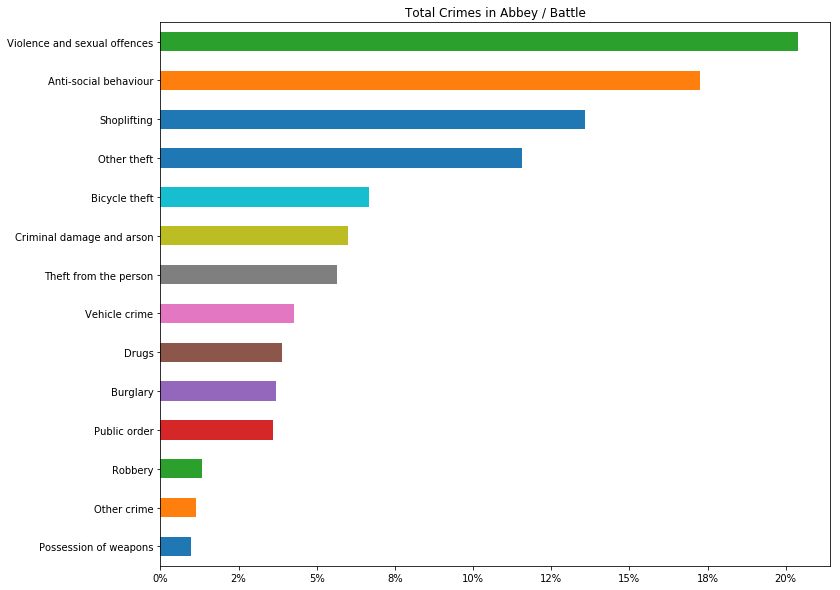

In [14]:
fig, axes = plt.subplots(figsize=(12,10))

data=df['Category'].value_counts().sort_values()
data=data.div(data.sum())

data.plot.barh(ax=axes,title='Total Crimes in ' + my_neighbourhood.name,figsize=(12,10));
vals = axes.get_xticks()
axes.set_xticklabels(['{:,.0%}'.format(x) for x in vals]);

In [15]:
plot_width=800
plot_height=500
title = 'Crime in ' + my_neighbourhood.name + ' from ' + \
    month_name[df['Date'].min().month] +' '+ str(df['Date'].min().year) + ' to ' +\
    month_name[df['Date'].max().month] +' '+ str(df['Date'].max().year)

data = df.groupby(['Date']).count()[['id']]
y_range=(0,round(data['id'].max()+5,-1))

p = figure(plot_width=plot_width, plot_height=plot_height, y_range=y_range,x_axis_type="datetime")
p.title.text = title

data = df.groupby(['Date']).count()[['id']]
p.line(x=data.index,y=data.id,color='green',line_width=4)

p.legend.location = "top_left"
p.legend.click_policy="hide"
p.legend.label_text_font_size = "12pt"
p.legend.background_fill_alpha = 0
p.yaxis.axis_label='Monthly Crime Rate'

show(p)

In [16]:
au=df.groupby(['Longitude','Latitude','Location']).count()
au.reset_index(inplace=True)
au['count']=au['id']
au=au.drop(columns=['id','Date','Category'])

coordsEN=[LongLat_to_EN(au.iloc[i]['Longitude'],au.iloc[i]['Latitude']) for i in range(len(au))]
x = [coordsEN[i][0] for i in range(len(coordsEN))]
y =[ coordsEN[i][1] for i in range(len(coordsEN))]
au['x'],au['y']=x,y
maxcount = au['count'].max() 
scale =(maxcount/100.)
au['size']=au['count'].div(scale)
source=ColumnDataSource(au)

p = figure(x_axis_type="mercator", y_axis_type="mercator",
           plot_width=1000, plot_height=600)
p.title.text='Total Crime in ' + my_neighbourhood.name
p.add_tile(CARTODBPOSITRON)
p.circle(x='x', y='y', size='size',source=source,fill_alpha=0.5,fill_color='darkred')

show(p)

In [17]:
crimes = df['Category'].value_counts()
crimes = [str(i) for i in crimes.index]
if len(crimes)!=14:
    crimes = [str(crime.name) for crime in api.get_crime_categories()]
colors = ['lightblue','red','yellowgreen','gold','orange','fuchsia',
          'brown','blue','purple','maroon','yellow',
         'indigo','darkgreen','aquamarine']
colours = dict(zip(crimes,colors))

p = figure(x_axis_type="mercator", y_axis_type="mercator",
           plot_width=1000, plot_height=600)
p.title.text='Types of Crime in ' + my_neighbourhood.name
p.add_tile(CARTODBPOSITRON)

for category in crimes:
    dg=df[df['Category']==category]
    au=dg.groupby(['Longitude','Latitude','Location']).count()
    au.reset_index(inplace=True)
    au['count']=au['id']
    au=au.drop(columns=['id','Date','Category'])
    coordsEN=[LongLat_to_EN(au.iloc[i]['Longitude'],au.iloc[i]['Latitude']) for i in range(len(au))]
    x = [coordsEN[i][0] for i in range(len(coordsEN))]
    y =[ coordsEN[i][1] for i in range(len(coordsEN))]
    au['x'],au['y']=x,y
    au['size']=au['count'].div(scale/5.)
    source=ColumnDataSource(au)
    p.circle(x='x', y='y', size='size',source=source,fill_alpha=0.4,fill_color=colours[category],line_width=0.2,legend = category)

p.legend.location = "top_left"
p.legend.click_policy="hide"
p.legend.label_text_font_size = "12pt"
p.legend.background_fill_alpha = 0

show(p)